<a href="https://colab.research.google.com/github/kobeisfree94/Projects/blob/master/COVID19_Vaccine_Mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COVID19 Vaccine/Mortality Analysis by **박산성**

**Objective: **
Analyze the Relationship Between Vaccination/Positivity/Mortality rate of the Covid19 Virus


In [ ]:
pip install -U matplotlib

In [ ]:
pip install category_encoders

In [ ]:
pip install eli5==0.11.0

In [ ]:
pip install pdpbox

In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
from scipy import stats



In [ ]:
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/My Drive/Data AI_BootCamp//DataSets/owid-covid-data_3.csv') #kaggle

print(df.shape)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(83656, 59)


EDA
- Choose features for analysis
- Deal with missing values
- Check for duplicates

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
#Choose features for analysis DATAFRAME

df = df.loc[:,['iso_code', 'continent', 'location', 'date', 
          'total_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed',
          'icu_patients','hosp_patients', 
          'new_tests_smoothed', 'total_tests',
          'total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations_smoothed','population']
      ]

#Confirmed Cases = 'total_cases', 'new_cases_smoothed'
#Confirmed Deaths = 'total_deaths', 'new_deaths_smoothed'
#Hospital & ICU = 'icu_patients,' 'hosp_patients'
#Tests & Positivity = 'new_tests_smoothed', 'total_tests','positive_rate'
#Vaccinations 'total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations'
#Others 'iso_code', 'continent', 'location', 'date','population'

In [ ]:
#Set date as datetime
df.date= df.date.astype(np.datetime64)

In [ ]:
df.isna().sum().sort_values(ascending=False)

people_fully_vaccinated      77945
people_vaccinated            75814
total_vaccinations           75113
icu_patients                 74898
hosp_patients                73084
new_vaccinations_smoothed    69927
total_tests                  45712
new_tests_smoothed           39853
total_deaths                 11585
continent                     4048
new_deaths_smoothed           2980
new_cases_smoothed            2980
total_cases                   1977
population                     542
location                         0
date                             0
iso_code                         0
dtype: int64

In [ ]:
df[df.continent.isna()].location.unique()

array(['Africa', 'Asia', 'Europe', 'European Union', 'International',
       'North America', 'Oceania', 'South America', 'World'], dtype=object)

In [ ]:
#Fill missing data with location value
df['continent'] = df['continent'].fillna(df['location'])

In [ ]:
df[df.population.isna()].location.unique()

array(['International', 'Northern Cyprus'], dtype=object)

In [ ]:
df[df.location.str.contains('Northern Cyprus')].info()
df[df.location.str.contains('Northern Cyprus')].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 55926 to 56025
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   iso_code                   100 non-null    object        
 1   continent                  100 non-null    object        
 2   location                   100 non-null    object        
 3   date                       100 non-null    datetime64[ns]
 4   total_cases                0 non-null      float64       
 5   new_cases_smoothed         0 non-null      float64       
 6   total_deaths               0 non-null      float64       
 7   new_deaths_smoothed        0 non-null      float64       
 8   icu_patients               0 non-null      float64       
 9   hosp_patients              0 non-null      float64       
 10  new_tests_smoothed         0 non-null      float64       
 11  total_tests                0 non-null      float64       
 12  to

iso_code                       0
continent                      0
location                       0
date                           0
total_cases                  100
new_cases_smoothed           100
total_deaths                 100
new_deaths_smoothed          100
icu_patients                 100
hosp_patients                100
new_tests_smoothed           100
total_tests                  100
total_vaccinations            93
people_vaccinated             96
people_fully_vaccinated       96
new_vaccinations_smoothed      1
population                   100
dtype: int64

In [ ]:
#Drop NaN(Northern Cyprus and International) in 'population'
df.population = df.population.dropna()
df= df.dropna(subset=['population'])

In [ ]:
 #Cumulative data = grouped by location and fillna with forward fill(using value of the last valid observation)
 df[['iso_code', 'continent', 'location', 'date', 
          'total_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed',
          'icu_patients','hosp_patients', 
          'new_tests_smoothed', 'total_tests',
          'total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations_smoothed','population']]= df.groupby('location')[['iso_code', 'continent', 'location', 'date', 
          'total_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed',
          'icu_patients','hosp_patients', 
          'new_tests_smoothed', 'total_tests',
          'total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations_smoothed','population']].fillna(method='ffill').fillna(0)

In [ ]:
#Non-cumulative(new) data = fill NaN with the difference between 2 rows using .diff
df.new_cases_smoothed=df.groupby('location')['new_cases_smoothed'].fillna(df.groupby('location')['total_cases'].diff(periods=1)).fillna(0)
df.new_deaths_smoothed=df.groupby('location')['new_deaths_smoothed'].fillna(df.groupby('location')['total_deaths'].diff(periods=1)).fillna(0)
df.new_tests_smoothed=df.groupby('location')['new_tests_smoothed'].fillna(df.groupby('location')['total_tests'].diff(periods=1)).fillna(0)
df.new_vaccinations_smoothed=df.groupby('location')['new_vaccinations_smoothed'].fillna(df.groupby('location')['total_vaccinations'].diff(periods=1)).fillna(0)

In [ ]:
#Rename the "_smoothed" columns for the sake of convenience
df.rename(columns= {'new_cases_smoothed': 'new_cases'}, inplace=True)
df.rename(columns= {'new_deaths_smoothed': 'new_deaths'}, inplace=True)
df.rename(columns= {'new_tests_smoothed': 'new_tests'}, inplace=True)
df.rename(columns= {'new_vaccinations_smoothed': 'new_vaccinations'}, inplace=True)

In [ ]:
#Check for Missing Values
df.isna().sum().sort_values(ascending=False)

population                 0
new_deaths                 0
continent                  0
location                   0
date                       0
total_cases                0
new_cases                  0
total_deaths               0
icu_patients               0
new_vaccinations           0
hosp_patients              0
new_tests                  0
total_tests                0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
iso_code                   0
dtype: int64

In [ ]:
#Check for duplicates
df.duplicated().sum()

#0 duplicates

Findings and Inferences with Visualization
- Compare World Data

In [ ]:
#World Comparisons
world_comparison= df.groupby('location')['iso_code', 'continent', 'date', 
          'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
          'icu_patients','hosp_patients', 
          'new_tests', 'total_tests',
          'total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations','population'].max().sort_values(by='continent').reset_index()
world_comparison['percent_population_vaccinated']= world_comparison['people_vaccinated']/world_comparison['population']
world_comparison['percent_population_death']= world_comparison['total_deaths']/world_comparison['population']
world_comparison= world_comparison.loc[world_comparison['location'] != world_comparison['continent']].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,location,iso_code,continent,date,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,new_tests,total_tests,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,population,percent_population_vaccinated,percent_population_death
0,Zimbabwe,ZWE,Africa,2021-04-23,38045.0,956.143,1556.0,43.143,0.0,0.0,3710.0,478757.0,365985.0,319732.0,46253.0,14071.0,14862927.0,0.021512,0.000105
1,Cameroon,CMR,Africa,2021-04-23,65998.0,2387.857,991.0,35.714,0.0,0.0,0.0,0.0,400.0,400.0,0.0,400.0,26545864.0,0.000015,0.000037
2,Saint Helena,SHN,Africa,2021-04-09,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,4572.0,3563.0,1009.0,75.0,6071.0,0.586888,0.000000
3,Cape Verde,CPV,Africa,2021-04-23,21784.0,258.429,201.0,2.000,0.0,0.0,567.0,0.0,2184.0,2184.0,0.0,364.0,555988.0,0.003928,0.000362
4,Rwanda,RWA,Africa,2021-04-23,24459.0,353.000,328.0,4.714,0.0,0.0,9108.0,1273629.0,349702.0,349702.0,0.0,24860.0,12952209.0,0.026999,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Peru,PER,South America,2021-04-23,1745655.0,9928.286,59012.0,743.857,0.0,0.0,18469.0,3195388.0,1347953.0,786872.0,561081.0,35195.0,32971846.0,0.023865,0.001790
205,Colombia,COL,South America,2021-04-23,2740544.0,17857.000,70446.0,411.714,0.0,0.0,77075.0,14095309.0,4224659.0,2904408.0,1320251.0,122556.0,50882884.0,0.057080,0.001384
206,Ecuador,ECU,South America,2021-04-23,371306.0,2191.714,18062.0,597.000,0.0,0.0,6580.0,1186632.0,675510.0,486524.0,188986.0,27197.0,17643060.0,0.027576,0.001024
207,Argentina,ARG,South America,2021-04-23,2824652.0,23944.571,61176.0,788.857,0.0,0.0,50149.0,8275984.0,6807411.0,5955371.0,852040.0,169014.0,45195777.0,0.131768,0.001354


Top Countries With More Than 10 million Cases

In [ ]:
#Countries With More than 10m 
country_pop_more_than_10m= world_comparison[world_comparison['population']>10000000].reset_index().drop('index', axis=1)


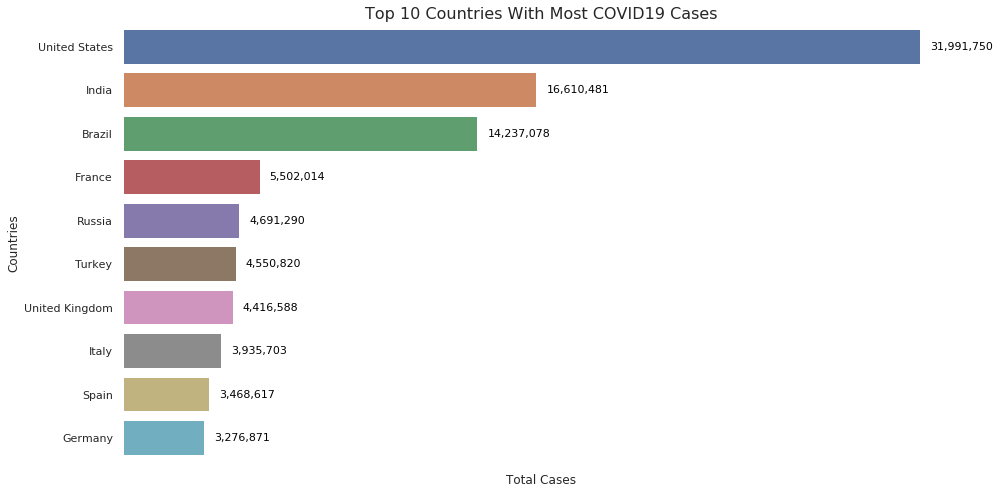

In [ ]:
#Top 10 countries (population > 10 millons) have the most covid cases
top_10_total_cases = country_pop_more_than_10m[['location','date', 'population','total_cases']].sort_values(by='total_cases',ascending=False).reset_index(drop=True).head(10)

sns.set_theme(style='white')
f, ax = plt.subplots(figsize=(15, 8))
ax= sns.barplot(x='total_cases' , y='location', data=top_10_total_cases)
sns.despine(left=True, bottom=True)
ax.set(xticklabels=[]) 
ax.tick_params(bottom=False)

ax.axes.set_title('Top 10 Countries With Most COVID19 Cases',fontsize=16)
ax.set_xlabel('Total Cases')
ax.set_ylabel('Countries',fontsize=12)

#set annotation
for p in ax.patches:
    ax.annotate('{:,}'.format(int(p.get_width())), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(10, 0), textcoords='offset points', ha='left', va='center', color='black', fontsize=11);

Comparison By Country

In [ ]:
#Dataframe for Top10
top10 = ['United States', 'India', 'Brazil', 'Russia', 'United Kingdom', 'Italy', 'France', 'Turkey', 'Spain', 'Germany']
top10= df[df.location.isin(top10)].reset_index().drop('index', axis=1).sort_values(by='date', ascending=True)
top10['percent_population_vaccinated']= top10['people_vaccinated']/ top10['population']
top10['percent_population_death']= top10['total_deaths']/top10['population']
top10['percent_increase/decrease'] = top10['total_cases'].pct_change(periods=1, fill_method='ffill')
top10['percent_increase/decrease'].replace([np.inf, -np.inf], np.nan, inplace=True)
top10['percent_increase/decrease']= top10['percent_increase/decrease'].fillna(0)
top10= top10.loc[top10['location'] != top10['continent']].reset_index(drop=True)

In [ ]:
#Dataframe for South Korea
#south_korea = df[df['location'] == 'South Korea'].reset_index().drop('index', axis=1)
#south_korea['percent_population_vaccinated']= south_korea['people_vaccinated']/ south_korea['population']
#south_korea['percent_population_death']= south_korea['total_deaths']/south_korea['population']
#south_korea['percent_increase/decrease'] = south_korea['total_cases'].pct_change(periods=1, fill_method='ffill')
#south_korea['percent_increase/decrease'].replace([np.inf, -np.inf], np.nan, inplace=True)
#south_korea['percent_increase/decrease']= south_korea['percent_increase/decrease'].fillna(0)
#south_korea= south_korea.loc[south_korea['location'] != south_korea['continent']].reset_index(drop=True)

In [ ]:
#Dataframe for US
#united_states = df[df['location'] == 'United States'].reset_index().drop('index', axis=1)
#united_states['percent_population_vaccinated']= united_states['people_vaccinated']/ united_states['population']
#united_states['percent_population_death']= united_states['total_deaths']/united_states['population']
#united_states['percent_increase/decrease'] = united_states['total_cases'].pct_change(periods=1, fill_method='ffill')
#united_states['percent_increase/decrease'].replace([np.inf, -np.inf], np.nan, inplace=True)
#united_states['percent_increase/decrease']= united_states['percent_increase/decrease'].fillna(0)
#united_states= united_states.loc[united_states['location'] != united_states['continent']].reset_index(drop=True)

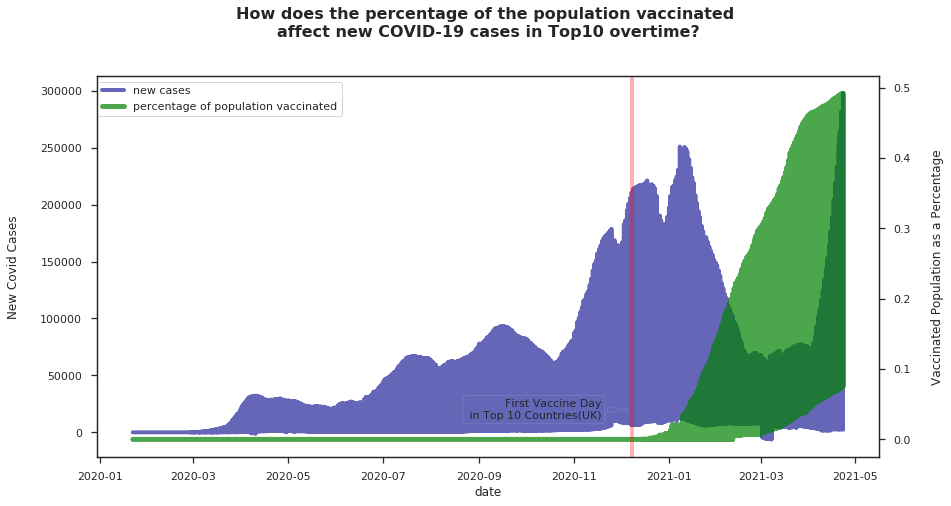

In [ ]:
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(top10.date, top10.new_cases, 'darkblue', label = 'new cases', linewidth = 4, alpha= 0.6)

ax2 = ax.twinx()
ax2.plot(top10.date, top10.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 5, alpha= 0.7)

ax.set_xlabel('date')
ax.set_ylabel(r'New Covid Cases', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)


plt.axvline(dt.datetime(2020,12,8), linewidth = 4, color='red',alpha= 0.3);



ax.annotate('First Vaccine Day\n in Top 10 Countries(UK)', xy=(dt.datetime(2020,12,8),20000),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=11, ha='right', va='center',
             bbox=dict(boxstyle='round', alpha=0.1),
             arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=0.1))

ax.axes.set_title('How does the percentage of the population vaccinated \naffect new COVID-19 cases in Top10 overtime?',fontsize=16, weight='bold', pad=40)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);

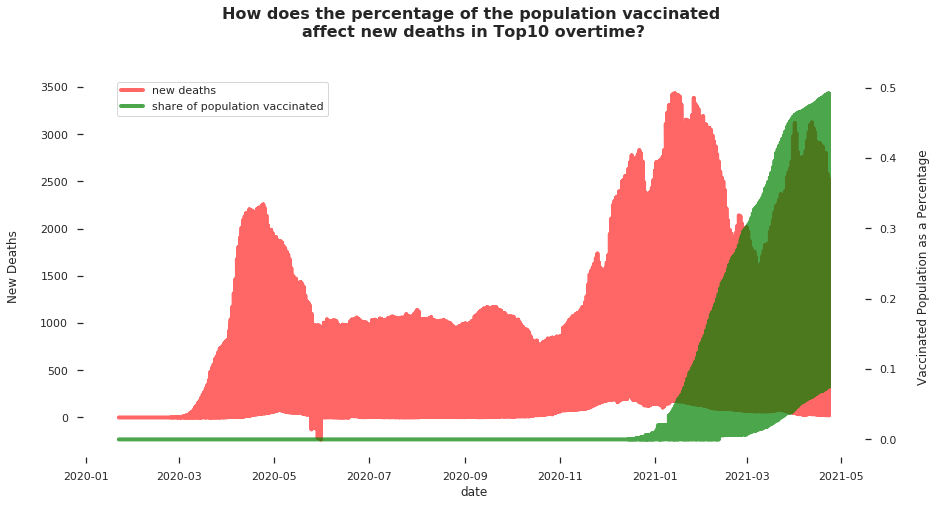

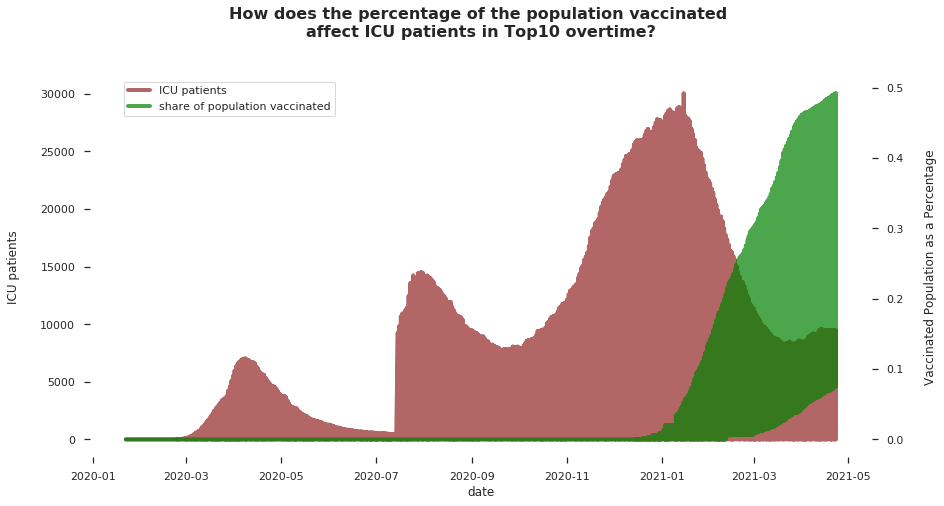

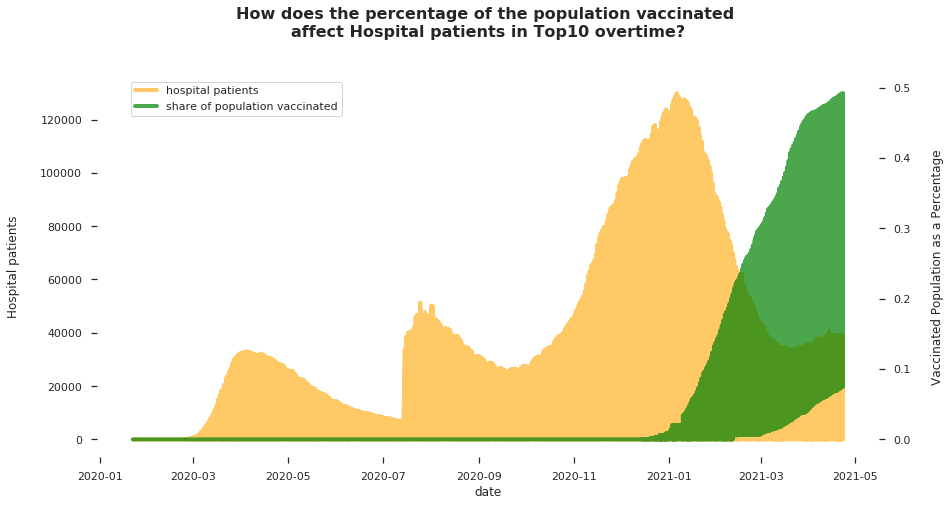

In [ ]:
#New deaths time series
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(top10.date, top10.new_deaths, 'red', label = 'new deaths', linewidth = 4, alpha= 0.6)

ax2 = ax.twinx()
ax2.plot(top10.date, top10.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 4, alpha= 0.7)

ax.set_xlabel('date')
ax.set_ylabel(r'New Deaths', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)

ax.axes.set_title('How does the percentage of the population vaccinated \naffect new deaths in Top10 overtime?',fontsize=16, weight='bold', pad=40)

sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);



#ICU patients time series
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(top10.date, top10.icu_patients, 'maroon', label = 'ICU patients', linewidth = 4, alpha= 0.6)


ax2 = ax.twinx()
ax2.plot(top10.date, top10.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 4, alpha= 0.7)
ax.set_xlabel('date')
ax.set_ylabel(r'ICU patients', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)

ax.axes.set_title('How does the percentage of the population vaccinated \naffect ICU patients in Top10 overtime?',fontsize=16, weight='bold', pad=40)

sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);

#Hospital patients time series
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(top10.date, top10.hosp_patients, 'orange', label = 'hospital patients', linewidth = 4, alpha= 0.6)


ax2 = ax.twinx()
ax2.plot(top10.date, top10.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 4, alpha= 0.7)
ax.set_xlabel('date')
ax.set_ylabel(r'Hospital patients', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)

ax.axes.set_title('How does the percentage of the population vaccinated \naffect Hospital patients in Top10 overtime?',fontsize=16, weight='bold', pad=40)

sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);

Prediction Model
- Regression Model to Predict New Deaths
- Observe Analysis using PDP

In [ ]:
#Change Date to Integer Top10
top10['date'] = top10['date'].apply(lambda x: x.value) 

In [ ]:
#Linear Regression Model
from sklearn.model_selection import train_test_split

target = 'new_deaths'
train = top10.sample(frac=0.75,random_state=0)
test = top10.drop(train.index)
features = ['percent_population_vaccinated', 'new_cases']
train,val =train_test_split(train, train_size=0.8, random_state=1)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

train.shape, val.shape, test.shape

((2666, 20), (667, 20), (1111, 20))

In [ ]:
#Baseline Model
train[target].mean()

404.54956901725416

In [ ]:
from sklearn.linear_model import LinearRegression


linear = make_pipeline(  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2 Train: ', linear.score(X_train, y_train))
print('R^2 Val: ', linear.score(X_val, y_val))
print('R^2 Test: ', linear.score(X_test, y_test))

R^2 Train:  0.6128878206207589
R^2 Val:  0.7042694213875741
R^2 Test:  0.6292976521590805


In [ ]:
#Gradient Boost and Cross Validation
target = 'new_deaths'
train, test= train_test_split(top10, train_size=0.8, random_state=5)
train, val= train_test_split(train, train_size=0.8, random_state=6)
train.shape, test.shape, val.shape

((2844, 20), (889, 20), (711, 20))

In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
from scipy.stats import randint, uniform
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', 
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

boosting.fit(X_train, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )
search.fit(X_train, y_train);

[0]	validation_0-rmse:545.497	validation_1-rmse:608.07
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:469.297	validation_1-rmse:530.736
[2]	validation_0-rmse:411.507	validation_1-rmse:470.813
[3]	validation_0-rmse:366.485	validation_1-rmse:423.914
[4]	validation_0-rmse:335.066	validation_1-rmse:392.016
[5]	validation_0-rmse:312.39	validation_1-rmse:370.456
[6]	validation_0-rmse:293.743	validation_1-rmse:350.527
[7]	validation_0-rmse:281.4	validation_1-rmse:338.147
[8]	validation_0-rmse:272.781	validation_1-rmse:330.284
[9]	validation_0-rmse:266.776	validation_1-rmse:324.885
[10]	validation_0-rmse:261.807	validation_1-rmse:321.839
[11]	validation_0-rmse:257.724	validation_1-rmse:318.728
[12]	validation_0-rmse:254.003	validation_1-rmse:315.605
[13]	validation_0-rmse:251.705	validation_1-rmse:315.216
[14]	validation_0-rmse:249.595	validation_1-rmse:312.949


In [ ]:
y_pred = boosting.predict(X_train)
print('R^2', r2_score(y_train, y_pred))

R^2 0.8569947040676354


In [ ]:
y_pred = boosting.predict(X_val)
print('R^2', r2_score(y_val, y_pred))

R^2 0.7456710828029147


In [ ]:
y_pred = boosting.predict(X_test)
print('R^2', r2_score(y_test, y_pred))

R^2 0.8436050919106695
